# Markov Decision Processes (MDP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1(a) and 1(b)

In [2]:
# Grid world:
L = 8
W = 8
heading = 12

# State space S where state s(x,y,h) = s(x-coordinate, y-coordinate, h-heading):
S = []
for x in range(L):
    for y in range(W):
        for h in range(heading):
            S.append((x,y,h))

nS = len(S)
print("The size of state space Ns is %d." % (nS))

# Action space where action a(move, turn):
#moves: 
still = 0
forward = 1
backward = 2
#turns:
turn_left = -1
turn_right = 1
turn_none = 0

# Action space A where action a(move, turn):
A = []
moves = [still, forward, backward] 
turns = [turn_none, turn_left, turn_right]

for move in moves:
    if move != still:
        for turn in turns:
            A.append((move, turn))
    else:
        A.append((still, turn_none))

nA = len(A)
print("The size of action space Na is %d." % (nA))

The size of state space Ns is 768.
The size of action space Na is 7.


## Question 1(c)

In [3]:
def transition_prob(s, a, s_, pe):
    """
    Transition_prob function that returns the probability that given state s and action a and error pe,
    leads to new state s_
    
    Arguments:
        s(x, y, h) = current state
        a(moves, turns) = action taken 
        s_(x_, y_, h_) = new state 
        pe = pre-rotation error when moving forward or backwards. 0 < pe <= 0.5
    
    Return:
        psa(s, a, s_) = transition probability to new state given current state and action
    """
    if not (pe >= 0 and pe <= 0.5):  # pre-rotation error is bounded: 0 < pe <= 0.5
        raise ValueError("pre-rotation probability pe must be bounded 0 < pe <= 0.5")
    
    #Robot pointing to different headings:
        # heading = [2,3,4] and move "forward"  = +x direction = [1, 0]
        # heading = [8,9,10] and move "forward" = -x direction = [-1,0]
        # heading = [11,0,1] and move "backward"= -y direction = [0,-1]
        # heading = [5,6,7] and move "backward" = +y direction = [0, 1]
        # pre-rotation error: not pre-rotate (1-2*pe), heading+1 (pe), heading-1 (pe)
    #p_heading[heading] = [ ( [move direction], heading, pre-rotation error) ]
    p_heading = {}
    p_heading[0]  = [ ([0, 1], 0, 1-2*pe),   ([0, 1], 1, pe),   ([0, 1], 11, pe) ]
    p_heading[1]  = [ ([0, 1], 1, 1-2*pe),   ([1, 0], 2, pe),   ([0, 1], 0, pe)  ]
    p_heading[2]  = [ ([1, 0], 2, 1-2*pe),   ([1, 0], 3, pe),   ([0, 1], 1, pe)  ] 
    p_heading[3]  = [ ([1, 0], 3, 1-2*pe),   ([1, 0], 4, pe),   ([1, 0], 2, pe)  ]
    p_heading[4]  = [ ([1, 0], 4, 1-2*pe),   ([0, -1], 5, pe),  ([1, 0], 3, pe)  ]
    p_heading[5]  = [ ([0, -1], 5, 1-2*pe),  ([0, -1], 6, pe),  ([1, 0], 4, pe)  ]
    p_heading[6]  = [ ([0, -1], 6, 1-2*pe),  ([0, -1], 7, pe),  ([0, -1], 5, pe) ]
    p_heading[7]  = [ ([0, -1], 7, 1-2*pe),  ([-1, 0], 8, pe),  ([0, -1], 6, pe) ]
    p_heading[8]  = [ ([-1, 0], 8, 1-2*pe),  ([-1, 0], 9, pe),  ([0, -1], 7, pe) ]
    p_heading[9]  = [ ([-1, 0], 9, 1-2*pe),  ([-1, 0], 10, pe), ([-1, 0], 8, pe) ]
    p_heading[10] = [ ([-1, 0], 10, 1-2*pe), ([0, 1], 11, pe),  ([-1, 0], 9, pe) ]
    p_heading[11] = [ ([0, 1], 11, 1-2*pe),  ([0, 1], 0, pe),   ([-1, 0], 10, pe)]
    
    
    # psa(s_)=prob - probability transition matrix by making a dictionary with key:new states, value: probability
    psa = {}
    if a[0] == forward:            # action[move] = forward
        for i in p_heading[s[2]]: 
            x = s[0] + i[0][0]
            x_ = x if (x<=L-1 and x>=0) else s[0] # no movement if off the grid
            
            y = s[1] + i[0][1]
            y_ = y if (y<=W-1 and y>=0) else s[1] # no movement if off the grid
            
            h_ = (a[1] + i[1]) % 12 
            
            psa[(x_, y_, h_)] = i[2]
            
    elif a[0] == backward:         # action[move] = backward
        for i in p_heading[s[2]]:  
            x = s[0] - i[0][0]
            x_ = x if (x<=L-1 and x>=0) else s[0] # no movement if off the grid
            
            y = s[1] - i[0][1]
            y_ = y if (y<=W-1 and y>=0) else s[1] # no movement if off the grid
            
            h_ = (a[1] + i[1]) % 12
            
            psa[(x_, y_, h_)] = i[2]    
            
    else:                          # action[move] = still (no movement and no turn)
        psa[s] = 1 
    
    if s_ in psa.keys():
        return psa[s_]   # return probability if s_ is found in psa matrix else return 0
    else:
        return 0

## Question 1(d)

In [4]:
def next_state(s, a, pe):
    """
    Next_state function returns the next state s_ given initial state, action, and error probability
    
    Arguments:
        s(x, y, h) = initial state
        a(moves, turns) = action taken 
        pe = pre-rotation error when moving forward or backwards. 0 < pe <= 0.5
    
    Return:
        s_(x_, y_, h_) = next state
    """
    if not (pe >= 0 and pe <= 0.5):  # pre-rotation error is bounded: 0 < pe <= 0.5
        raise ValueError("pre-rotation probability pe must be bounded 0 < pe <= 0.5")
    
    #Robot pointing to different headings:
        # heading = [2,3,4] and move "forward"  = +x direction = [1, 0]
        # heading = [8,9,10] and move "forward" = -x direction = [-1,0]
        # heading = [11,0,1] and move "backward"= -y direction = [0,-1]
        # heading = [5,6,7] and move "backward" = +y direction = [0, 1]
        # pre-rotation error: not pre-rotate (1-2*pe), heading+1 (pe), heading-1 (pe)
    #p_heading[heading] = [ ( [move direction], heading, pre-rotation error) ]
    p_heading = {}
    p_heading[0]  = [ ([0, 1], 0, 1-2*pe),   ([0, 1], 1, pe),   ([0, 1], 11, pe) ]
    p_heading[1]  = [ ([0, 1], 1, 1-2*pe),   ([1, 0], 2, pe),   ([0, 1], 0, pe)  ]
    p_heading[2]  = [ ([1, 0], 2, 1-2*pe),   ([1, 0], 3, pe),   ([0, 1], 1, pe)  ] 
    p_heading[3]  = [ ([1, 0], 3, 1-2*pe),   ([1, 0], 4, pe),   ([1, 0], 2, pe)  ]
    p_heading[4]  = [ ([1, 0], 4, 1-2*pe),   ([0, -1], 5, pe),  ([1, 0], 3, pe)  ]
    p_heading[5]  = [ ([0, -1], 5, 1-2*pe),  ([0, -1], 6, pe),  ([1, 0], 4, pe)  ]
    p_heading[6]  = [ ([0, -1], 6, 1-2*pe),  ([0, -1], 7, pe),  ([0, -1], 5, pe) ]
    p_heading[7]  = [ ([0, -1], 7, 1-2*pe),  ([-1, 0], 8, pe),  ([0, -1], 6, pe) ]
    p_heading[8]  = [ ([-1, 0], 8, 1-2*pe),  ([-1, 0], 9, pe),  ([0, -1], 7, pe) ]
    p_heading[9]  = [ ([-1, 0], 9, 1-2*pe),  ([-1, 0], 10, pe), ([-1, 0], 8, pe) ]
    p_heading[10] = [ ([-1, 0], 10, 1-2*pe), ([0, 1], 11, pe),  ([-1, 0], 9, pe) ]
    p_heading[11] = [ ([0, 1], 11, 1-2*pe),  ([0, 1], 0, pe),   ([-1, 0], 10, pe)]
    
    # state_prob_dict[probability] = next state s_
    state_prob_dict = {}
    if a[0] == forward:             # action[move] = forward
        for i in p_heading[s[2]]: 
            x = s[0] + i[0][0]
            x_ = x if (x<=L-1 and x>=0) else s[0] # no movement if off the grid
            
            y = s[1] + i[0][1]
            y_ = y if (y<=W-1 and y>=0) else s[1] # no movement if off the grid
            
            h_ = (a[1] + i[1]) % 12 
            
            if i[2] != 0:
                state_prob_dict[i[2]] = (x_, y_, h_)
            
    elif a[0] == backward:          # action[move] = backward
        for i in p_heading[s[2]]: 
            x = s[0] - i[0][0]
            x_ = x if (x<=L-1 and x>=0) else s[0] # no movement if off the grid
            
            y = s[1] - i[0][1]
            y_ = y if (y<=W-1 and y>=0) else s[1] # no movement if off the grid
            
            h_ = (a[1] + i[1]) % 12
            
            if i[2] != 0:
                state_prob_dict[i[2]] = (x_, y_, h_)
            
    else:                           # action[move] = still (no movement and no turn with psa=1)
        state_prob_dict[1] = s 
    
    return state_prob_dict

## Question 2(a)

In [5]:
def reward(s):
    """
    Reward function returns the reward given initial state
    
    Argument:
        s(x, y, h) = initial state
        
    Return:
        R = reward
    """
    if (s[0] in [0,7]) or (s[1] in [0,7]):  # Border states (Red)
        return -100
    elif (s[0]==3) and (s[1] in [4,5,6]):   # Lane markers (Yellow)
        return -10
    elif (s[0]==5) and (s[1]==6):           # Goal (Green)
        return 1
    else:
        return 0                            # All Other states

## Question 3(a)

In [6]:
def initial_policy(s):
    """
    Create initial policy of taking an action that gets you closest to the goal square
    
    Argument:
        s(x,y,h) = initial state
    
    Return:
        policy
    """
    policy = {}
    goal_square = [5, 6]

    for s in S:
    
        diff = [goal_square[0] - s[0], goal_square[1] - s[1]]  # diff = Goal - initial state
        
        if diff == [0,0]:                             # At Goal
            policy[s] = (still, turn_none) 

        # Move directions:
        if s[2] in [2,3,4]:                           # move +x direction = [1, 0]
            if (diff[0]>=0 or diff[1]==0):    
                move = forward
            else:
                move = backward

        elif s[2] in [8,9,10]:                        # move -x direction = [-1, 0]
            if (diff[0]<=0 or diff[1]==0):
                move = forward
            else:
                move = backward

        elif s[2] in [11,0,1]:                        # move -y direction = [0,-1]
            if (diff[1]>=0 or diff[0]==0):
                move = forward
            else:
                move = backward

        elif s[2] in [5,6,7]:                          
            if (diff[1]<=0 or diff[0]==0):            # move +y direction = [0, 1]
                move = forward
            else:
                move = backward

        # Turn directions:
        diff_theta = s[2]*30 - 90 + np.arctan2(diff[1], diff[0]) * 180 / np.pi
        if (diff_theta > 0) and (diff_theta < 180):
            turn = turn_left
        elif (diff_theta == 0) or (diff_theta == 180):
            turn = turn_none
        else:
            turn = turn_right

        policy[s] = (move, turn)
    
    return policy

## Question 3(b)

In [7]:
def plot_trajectory(policy, s, pe=0):
    """
    Plot_trajectory function generates and plots a trajectory of a robot given policy matrix, initial state and pre-rotation error
    
    Arguments:
        p = policy that maps all states to actions 
        s(x,y,h) = initial state 
        pe = pre-rotation error when moving forward or backwards (0 < pe <= 0.5) 
        
    Return:
        Plot of the trajectory of a robot 
    """
    if not (pe >= 0 and pe <= 0.5): # pre-rotation error is bounded: 0 < pe <= 0.5
        raise ValueError("pre-rotation probability pe must be bounded 0 < pe <= 0.5") 
    
    # Plot the trajectory:
    trajectory = []
    goal_square = [5, 6]
    s0 = s
    
    while True:
        trajectory.append([s0, policy[s0]])
        if (policy[s0] == (0,0)):                                      # No action
            break
        if (s0[0] == goal_square[0]) and (s0[1] == goal_square[1]):    # At Goal
            break
        P_state = next_state(s0, policy[s0], pe)
        state_max_prob = max(P_state.keys())     # max key of P_state is the highest prob
        s_next = P_state[state_max_prob]         # value of highest prob is the next state
        s0 = s_next
    
    # Grid world states
    fig = plt.figure(figsize = (L, W))
    ax = fig.add_subplot(1,1,1)
    plt.xlim((0,L))
    plt.ylim((0,W))
    plt.grid(True, color = 'k')
    
    # Plot border states as red
    from matplotlib.patches import Rectangle
    border1 = plt.Rectangle((0,0), 1, 8, color = 'r')
    border2 = plt.Rectangle((1,0), 7, 1, color = 'r')
    border3 = plt.Rectangle((7,1), 1, 7, color = 'r')
    border4 = plt.Rectangle((1,7), 6, 1, color = 'r')
    ax.add_patch(border1)
    ax.add_patch(border2)
    ax.add_patch(border3)
    ax.add_patch(border4)
    
    # Plot lane markers (yellow)
    lane1 = plt.Rectangle((3,4), 1, 3, color = 'y')
    ax.add_patch(lane1)
    
    # Plot goal (green)
    goal = plt.Rectangle((5,6), 1, 1, color = 'g')
    ax.add_patch(goal)
    
    # Start state:
    plt.plot(s[0]+0.5, s[1]+0.5, 'o', markersize = '5') # places dots in the center of each grid
    ax.arrow(s[0]+0.5, s[1]+0.5, 0.4*np.sin(30*s[2]*np.pi/180), 0.4*np.cos(30*s[2]*np.pi/180), \
             head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')
    
    # Plot all passing states
    for i in range(1, len(trajectory)):
        x1 = trajectory[i-1][0][0]      # first point
        y1 = trajectory[i-1][0][1]
        x2 = trajectory[i][0][0]
        y2 = trajectory[i][0][1]
        h = trajectory[i][0][2]
        plt.plot([x1+0.5, x2+0.5], [y1+0.5, y2+0.5], 'k--')
        plt.plot(x2+0.5, y2+0.5, 'x', markersize = '2')
        ax.arrow(x2+0.5, y2+0.5, 0.4*np.sin(30*h*np.pi/180),0.4*np.cos(30*h*np.pi/180), \
                 head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')
        
    plt.show()
    
    return trajectory

## Problem 3(c)

In [8]:
# Given initial state and initial policy:
s0 = (1, 6, 6)
policy0 = initial_policy(s0)

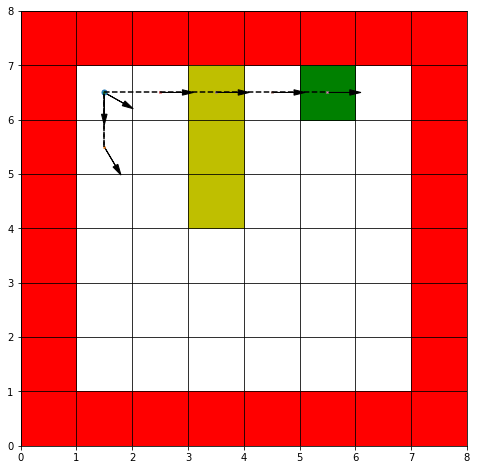

Trajectory [state, policy] of robot: 
 [[(1, 6, 6), (1, -1)], [(1, 5, 5), (2, -1)], [(1, 6, 4), (1, -1)], [(2, 6, 3), (1, 0)], [(3, 6, 3), (1, 0)], [(4, 6, 3), (1, 0)], [(5, 6, 3), (1, 0)]]


In [9]:
# Plot the robot's trajectory

plot1 = plot_trajectory(policy0, s0, pe=0)
print("Trajectory [state, policy] of robot: \n" , plot1)

## Question 3(d)

In [10]:
def policy_evaluation(policy, reward_fnc=reward, pe=0, discount=1, theta=0.001):
    """
    Policy_evaluation function evaluates a policy by returning a matrix of values when indexed by state s.
    
    Arguments:
        policy[s(x,y,h)] = a(move,turn) given policy that we need to evaluate
        reward_fnc: call the reward function, reward(s), for getting the immediate reward from that state
        pe: pre-rotation error when moving forward or backwards (0 < pe <= 0.5)
        discount: gamma discount factor
        theta: stop evaluation once V change is less than theta for all states
    
    Return:
        Dictionary of Value function with key: state, value: Value
    """
    V = {}
    
    for s in S:
        V[s] = 0                                                            # start with value = 0 for all states
    
    while True:
        delta = 0                                                           # stopping criterion initialized within the loop
        for s in S:
            v_new = 0
            P_state = next_state(s, policy[s], pe)                          # find all possible next states
            for prob in P_state.keys():
                s_next = P_state[prob]                                      # value of P_state[prob] is the next state
                v_new += prob * (reward_fnc(s_next) + discount * V[s_next]) # evaluate value for the given policy
            delta = max(delta, np.abs(v_new - V[s]))                        # delta across state seen thus far
            V[s] = v_new                                                    # update value function
        
        if delta < theta:                                                   # stopping criterion - iterate until no change in value across all states
            break
            
    return V

## Question 3(e)

In [11]:
# Given initial state and policy, evaluate the policy

V = policy_evaluation(policy0, discount=0.9)
V[s0]
print("Value of the trajectory using initial policy0 is: ", V[s0])

Value of the trajectory using initial policy0 is:  -484.9889082764241


## Question 3(f)

In [12]:
def policy_refinement(V, reward_fnc=reward, pe=0, discount=1):
    """
    Policy_refinement function that returns the optimal policy given one-step lookahead on value V
    
    Arguments:
        V: value of initial policy
        reward_fnc: call the reward function, reward(s), for getting the immediate reward from that state
        pe: pre-rotation error when moving forward or backwards (0 < pe <= 0.5)
        discount: gamma discount factor
    
    Return:
        policy: dictionary with key: state, value: action(move, turn)
    """
    
    policy = {}
    
    for s in S:
        action_values = np.zeros(nA)
        for i, a in enumerate(A):
            P_state = next_state(s, a, pe)
            for prob in P_state.keys():
                s_next = P_state[prob]
                action_values[i] += prob * (reward_fnc(s_next) + discount * V[s_next]) # evaluate value for each action
        
        max_action_index = np.argmax(action_values)                                    # pick the best index of action by one-step lookahead
        policy[s] = A[max_action_index]                                                # update policy = action that gives the max value
    
    return policy

## Question 3(g)

In [13]:
def policy_iteration(policy, reward_fnc=reward, pe=0, discount=1):
    """
    Policy_iteration function returns optimal policy (pi*) and optimal value (V*)
    
    Arguments:
        policy: initial policy
        reward_fnc: call the reward function, reward(s), for getting the immediate reward from that state
        pe: pre-rotation error when moving forward or backwards (0 < pe <= 0.5)
        discount: gamma discount factor
        
    Return:
        Tuple of the optimal policy and the optimal value function, (optimal policy, optimal value)
    """
    while True:
        
        V = policy_evaluation(policy, reward_fnc, pe, discount)         # evaluate the initial policy

        policy_updated = policy_refinement(V, reward_fnc, pe, discount) # refine the policy based on one-step lookahead

        if policy_updated == policy:                                    # convergence criterion - iterate until no change in policy across all states
            break
        else:
            policy = policy_updated 
            
    return policy, V

## Question 3(h) and 3(i)

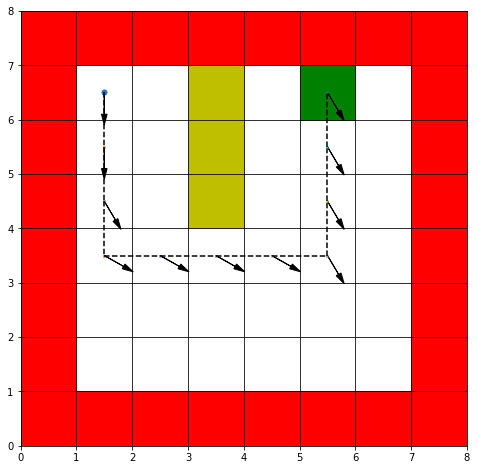

Time for Policy Iteration: 4.841061115264893 s
Trajectory [state, policy] using policy iteration: 
 [[(1, 6, 6), (1, 0)], [(1, 5, 6), (1, -1)], [(1, 4, 5), (1, -1)], [(1, 3, 4), (1, 0)], [(2, 3, 4), (1, 0)], [(3, 3, 4), (1, 0)], [(4, 3, 4), (1, 1)], [(5, 3, 5), (2, 0)], [(5, 4, 5), (2, 0)], [(5, 5, 5), (2, 0)], [(5, 6, 5), (0, 0)]]


In [14]:
# Given initial state and initial policy, plot the robot's trajectory using policy iteration
import time

start_time = time.time()
policy_optimal, V_optimal = policy_iteration(policy0, discount=0.9)
plot_PI = plot_trajectory(policy_optimal, s0, pe=0)
end_time = time.time()

print("Time for Policy Iteration: %s s" %str(end_time - start_time))
print("Trajectory [state, policy] using policy iteration: \n", plot_PI)

## Question 4(a)

In [15]:
def value_iteration(policy, reward_fnc=reward, pe=0, discount=1, theta=0.001):
    """
    Value_iteration function returns optimal policy (pi*) and optimal value (V*)
    
    Arguments:
        policy: initial policy
        reward_fnc: call the reward function, reward(s), for getting the immediate reward from that state
        pe: pre-rotation error when moving forward or backwards (0 < pe <= 0.5)
        discount: gamma discount factor
        theta: stop evaluation once V change is less than theta for all states
        
    Return:
        Tuple of the optimal policy and the optimal value function, (optimal policy, optimal value)
    """
    V = {}
    
    for s in S:
        V[s] = 0                                                                           # start with value = 0 for all states
    
    while True:
        delta = 0                                                                          # stopping criterion initialized within the loop
        for s in S:
            action_values = np.zeros(nA)                                                   # placeholder for value for each action start as all zeros vector
            for i, a in enumerate(A):
                P_state = next_state(s, a, pe)                                             # find all possible next states
                for prob in P_state.keys():
                    s_next = P_state[prob]                                                 # value of P_state[prob] is the next state
                    action_values[i] += prob * (reward_fnc(s_next) + discount * V[s_next]) # evaluate value for each action
            max_action_value = np.max(action_values)                                       # pick the action with max value
            max_action_index = np.argmax(action_values)                                    # pick the index of action with max value
        
            delta = max(delta, np.abs(max_action_value - V[s]))                            # delta across state seen thus far
            V[s] = max_action_value                                                        # update value fnc = value of action that gives max value
            policy[s] = A[max_action_index]                                                # update policy = action that gives the max value

        if delta < theta:                                                                  # stopping criterion - iterate until no change in value across all states
            break
            
    return policy, V

## Question 4(b) and 4(c)

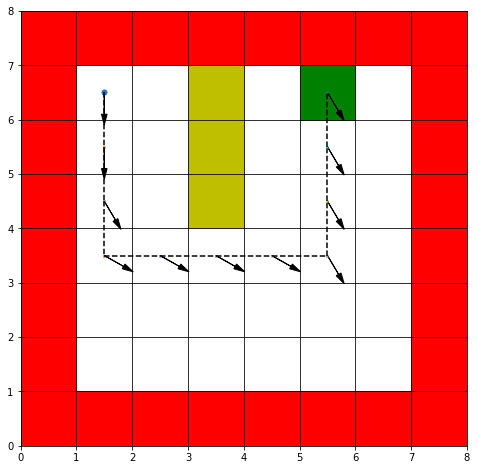

Time for Value Iteration: 2.5703539848327637 s
Trajectory [state, policy] using value iteration: 
 [[(1, 6, 6), (1, 0)], [(1, 5, 6), (1, -1)], [(1, 4, 5), (1, -1)], [(1, 3, 4), (1, 0)], [(2, 3, 4), (1, 0)], [(3, 3, 4), (1, 0)], [(4, 3, 4), (1, 1)], [(5, 3, 5), (2, 0)], [(5, 4, 5), (2, 0)], [(5, 5, 5), (2, 0)], [(5, 6, 5), (0, 0)]]


In [16]:
# Given initial state and initial policy, plot the robot's trajectory using value iteration
import time

start_time = time.time()
policy_optimal, V_optimal = value_iteration(policy0, discount=0.9)
plot_VI = plot_trajectory(policy_optimal, s0, pe=0)
end_time = time.time()

print("Time for Value Iteration: %s s" %str(end_time - start_time))
print("Trajectory [state, policy] using value iteration: \n", plot_VI)

## Question 5(a)

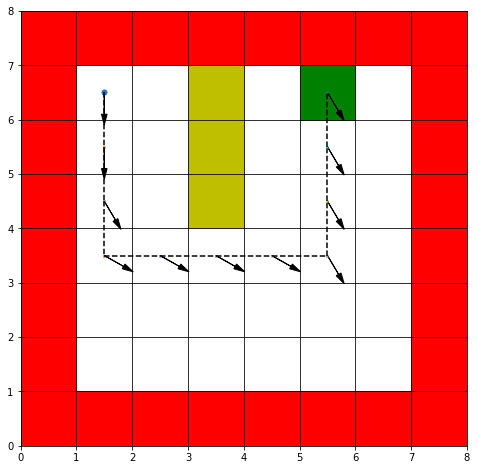

Trajectory [state, policy] of robot: 
 [[(1, 6, 6), (1, 0)], [(1, 5, 6), (1, -1)], [(1, 4, 5), (1, -1)], [(1, 3, 4), (1, 0)], [(2, 3, 4), (1, 0)], [(3, 3, 4), (1, 0)], [(4, 3, 4), (1, 1)], [(5, 3, 5), (2, 0)], [(5, 4, 5), (2, 0)], [(5, 5, 5), (2, 0)], [(5, 6, 5), (0, 0)]]


In [17]:
# Plot trajectory with pe=0.25
plot1 = plot_trajectory(policy0, s0, pe=0.25)
print("Trajectory [state, policy] of robot: \n" , plot1)

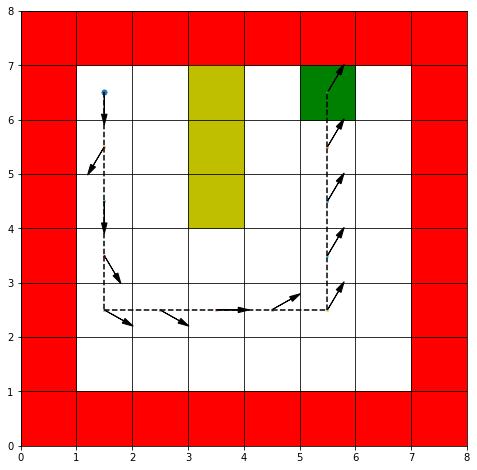

Time for Value Iteration with pe=0.25: 3.145966053009033 s
Trajectory [state, policy] using value iteration and pe=0.25: 
 [[(1, 6, 6), (1, 1)], [(1, 5, 7), (1, -1)], [(1, 4, 6), (1, -1)], [(1, 3, 5), (1, -1)], [(1, 2, 4), (1, 0)], [(2, 2, 4), (1, -1)], [(3, 2, 3), (1, -1)], [(4, 2, 2), (1, -1)], [(5, 2, 1), (1, 0)], [(5, 3, 1), (1, 0)], [(5, 4, 1), (1, 0)], [(5, 5, 1), (1, 0)], [(5, 6, 1), (0, 0)]]


In [18]:
# Given initial state and initial policy, re-plot the robot's trajectory using value iteration and pe=25%
start_time = time.time()
policy_optimal, V_optimal = value_iteration(policy0, pe=0.25, discount=0.9)
plot_VI_25 = plot_trajectory(policy_optimal, s0, pe=0.25)
end_time = time.time()
print("Time for Value Iteration with pe=0.25: %s s" %str(end_time - start_time))
print("Trajectory [state, policy] using value iteration and pe=0.25: \n", plot_VI_25)

## Question 5(b)

In [19]:
def new_reward(s):
    """
    New Reward function returns the reward given initial state
    
    Argument:
        s(x, y, h) = initial state
        
    Return:
        R = reward
    """
    if (s[0] in [0,7]) or (s[1] in [0,7]):       # Border states (Red)
        return -100
    elif (s[0]==3) and (s[1] in [4,5,6]):        # Lane markers (Yellow)
        return -10
    elif (s[0]==5) and (s[1]==6) and (s[2]==6):  # Goal (Green) *UPDATED*
        return 1
    else:
        return 0                                 # All Other states

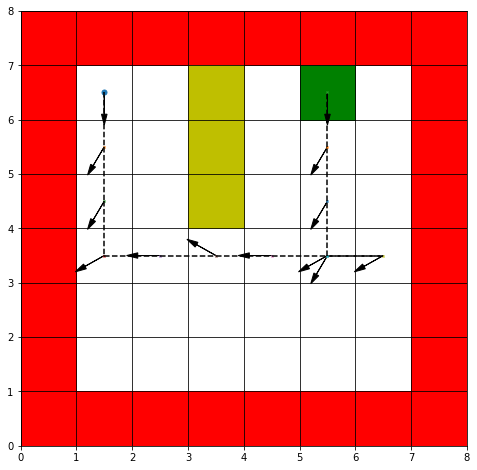

Time for Value Iteration with new reward, pe=0.25: 3.151163101196289 s
Trajectory [state, policy] using value iteration, new_reward function, and pe=0.25: 
 [[(1, 6, 6), (1, 1)], [(1, 5, 7), (1, 0)], [(1, 4, 7), (1, 1)], [(1, 3, 8), (2, 1)], [(2, 3, 9), (2, 1)], [(3, 3, 10), (2, -1)], [(4, 3, 9), (2, -1)], [(5, 3, 8), (2, 0)], [(6, 3, 8), (1, -1)], [(5, 3, 7), (2, 0)], [(5, 4, 7), (2, 0)], [(5, 5, 7), (2, -1)], [(5, 6, 6), (0, 0)]]


In [20]:
# Given initial state and initial policy, re-plot the robot's trajectory using value iteration, new_reward function and pe=25%
start_time = time.time()
policy_optimal, V_optimal = value_iteration(policy0, reward_fnc=new_reward, pe=0.25, discount=0.9)
plot_VI_R25 = plot_trajectory(policy_optimal, s0, pe=0.25)
end_time = time.time()
print("Time for Value Iteration with new reward, pe=0.25: %s s" %str(end_time - start_time))
print("Trajectory [state, policy] using value iteration, new_reward function, and pe=0.25: \n", plot_VI_R25)